In [75]:
import cv2
import os
import shutil as sh
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw, ImageFont, ImageCms
import dask.dataframe as dd
from dask.multiprocessing import get
from dask import delayed, compute
from dask.diagnostics import ProgressBar
import subprocess
os.chdir('/Users/iandouglas/Projects/Repos/generative-ai/')

#### Setup

Move gallery images into before and after folders so they can be accessed by the dataloader.

In [27]:
gallery_dir = 'data/image_extraction/progresspics/gallery'
galleries = os.listdir(gallery_dir)
[os.listdir(f"{gallery_dir}/{x}")for x in galleries[0:2]]

[['imgur_BMdqM_004_OmMXO2v.jpg',
  'imgur_BMdqM_003_dw0JL2M.jpg',
  'imgur_BMdqM_002_S62FoPS.jpg',
  'imgur_BMdqM_001_WDXyKXs.jpg'],
 ['imgur_zXvx0_003_DXgggtF.jpg',
  'imgur_zXvx0_002_aDrVOqE.jpg',
  'imgur_zXvx0_001_gN7WdB0.jpg',
  'imgur_zXvx0_004_xcv5yjV.jpg',
  'imgur_zXvx0_005_Xxs4PWP.jpg']]

In [28]:
before_dir = 'data/img/before'
after_dir = 'data/img/after'
[os.makedirs(x, exist_ok = True) for x in [before_dir, after_dir]]

[None, None]

In [29]:
def copy_before_after(dir_):
    filename = f"{dir_}.jpg"
    images = os.listdir(f"{gallery_dir}/{dir_}")
    if len(images) > 1:
        image_num = [int(x.split('_')[2]) for x in images]
        before = images[0]
        after = images[argmax(image_num)]
        sh.copy(f"{gallery_dir}/{dir_}/{before}",
                f"{before_dir}/{filename}")
        sh.copy(f"{gallery_dir}/{dir_}/{after}",
                f"{after_dir}/{filename}")

In [40]:
for i in galleries:
    copy_before_after(i)

In [30]:
print(len(os.listdir('data/img/before')))
len(os.listdir('data/img/after'))

8507


8507

### Convert all the images in before/after to jpg w/ RGB color format

### Splitting images

Before/after images that were downloaded as a single file need to be split. Most of the images are simply pasted together, while others have borders. If borders are detected, crop the individual images easily from them. Otherwise:

* Using a sliding window of size h x 2 (two pixels wide), find the columns that have the largest mean squared difference in hue (on greyscale).
* This is most likely the point where they created their collage and appended their two images.
* Search is narrowed to the inner 3/5 of the image.
* Except: if the pixel values are all identical, we have found a frame --> use this as the split point

In [31]:
def present_images(original, before, after):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the original image
    axes[0].imshow(original)
    axes[0].set_title('Original')
    axes[0].set_yticks([i * original.shape[0] // 15 for i in range(16)])  # Set 16 y-axis ticks
    axes[0].set_xticks([])

    # Plot the "before" image
    axes[1].imshow(before)
    axes[1].set_title('Before')
    axes[1].set_yticks([i * before.shape[0] // 15 for i in range(16)])  # Set 16 y-axis ticks
    axes[1].set_xticks([])

    # Plot the "after" image
    axes[2].imshow(after)
    axes[2].set_title('After')
    axes[2].set_yticks([i * after.shape[0] // 15 for i in range(16)])  # Set 16 y-axis ticks
    axes[2].set_xticks([])

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()
    

In [54]:
def find_best_line_and_split(file_path, before_dir=None, after_dir=None, save=True):
    filename = file_path.split('/')[-1]
    id_ = filename.split('.')[0]
    
    # Read the grayscale image
    img_gray = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    if not img_gray is None:
        # Window size
        # It should be as small as possible
        window_width = 2

        # Define the range for the window search (1/5 to 4/5 from the left)
        start_col = int(img_gray.shape[1] / 5)
        end_col = int(4 * img_gray.shape[1] / 5)

        # Initialize variables to store the best line information
        best_line_col1 = start_col
        best_line_col2 = start_col + window_width
        max_mse = 0 # start at no difference between columns

        # Iterate through columns within the specified range
        for col in range(start_col, end_col - window_width):
            # Extract two columns in the window
            window_cols = img_gray[:, col:col+window_width]

            # Look for a frame, but drop the very top in case the horizontal portion
            # of the frame is a different color than the vertical portion of the frame
            crop = int(window_cols.shape[0] / 15) # drop the top and bottom pixels
            window_crop = window_cols[crop:-crop, :]

            # Check if all pixels in this window have the same value (is a frame)
            if len(np.unique(window_crop)) == 1:
                best_line_col1 = col
                best_line_col2 = col + window_width
                break  # Stop the loop if the window is a frame

            # Calculate mean squared absolute difference
            mse = np.mean(np.square(np.diff(window_cols)))

            # Update best line if current mse is greater
            if mse > max_mse:
                max_mse = mse
                best_line_col1 = col
                best_line_col2 = col + window_width

        # Read the original color image to split it (don't save greyscale!)
        img_color = cv2.imread(file_path)

        # Crop the color image into "before" and "after"
        before_img = img_color[:, :best_line_col1, :]
        after_img = img_color[:, best_line_col2:, :]

        # Save the cropped color images with the original filename
        if save:
            out_before = f"{before_dir}/{filename}"
            out_after = f"{after_dir}/{filename}"
            cv2.imwrite(out_before, before_img)
            cv2.imwrite(out_after, after_img)
            # Return the filename for logging
            return filename
        else:
            present_images(img_color, before_img, after_img)

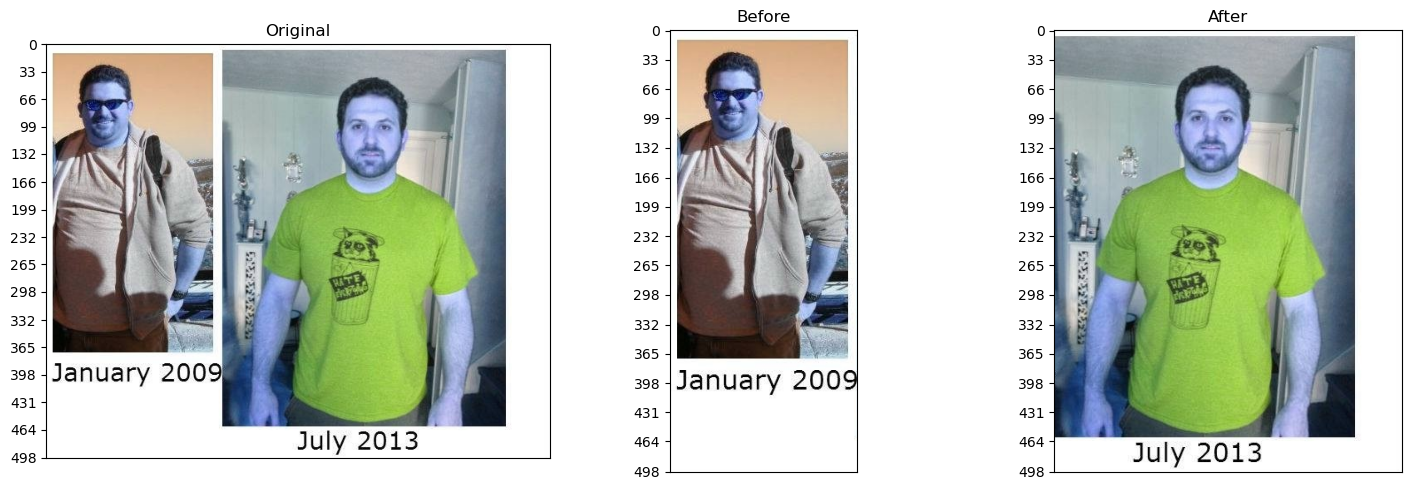

In [55]:
find_best_line_and_split(file_path = 'data/image_extraction/progresspics/url/1hwfpy.jpg', save=False)

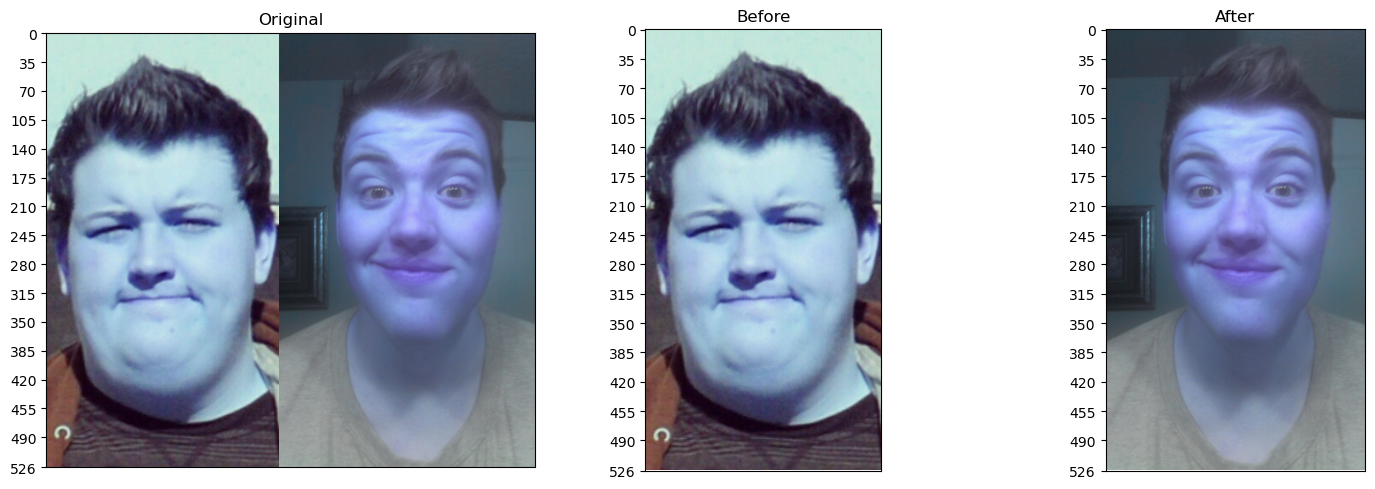

In [34]:
# Test on images where there is a frame
find_best_line_and_split(file_path = 'data/image_extraction/progresspics/url/1i2s37.jpg', save=False)

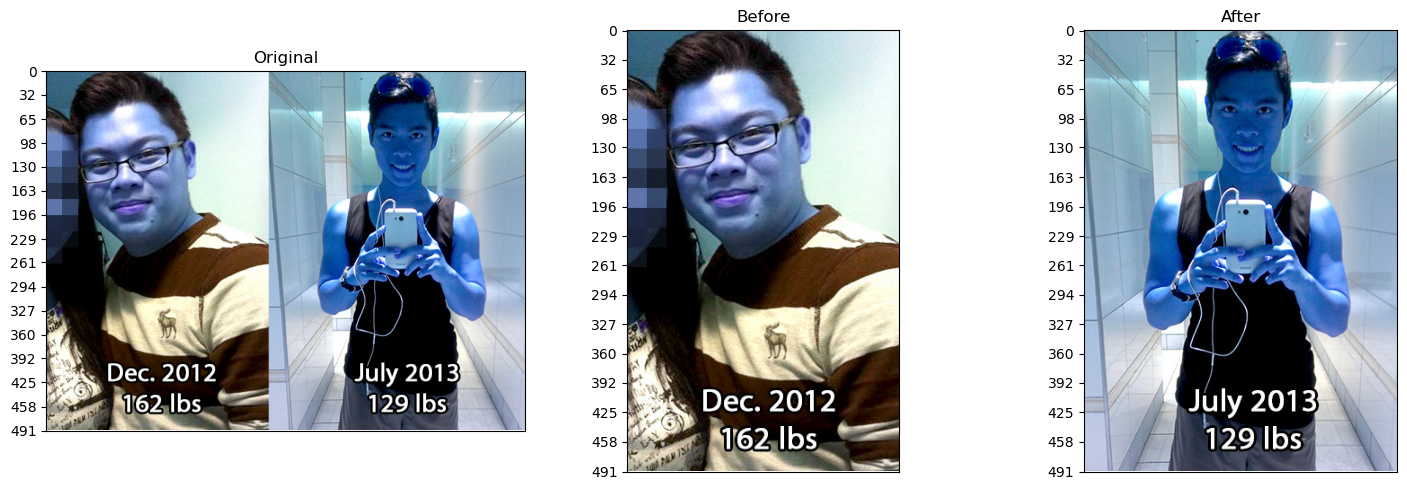

In [35]:
find_best_line_and_split(file_path = 'data/image_extraction/progresspics/url/1i6swt.jpg', save=False)

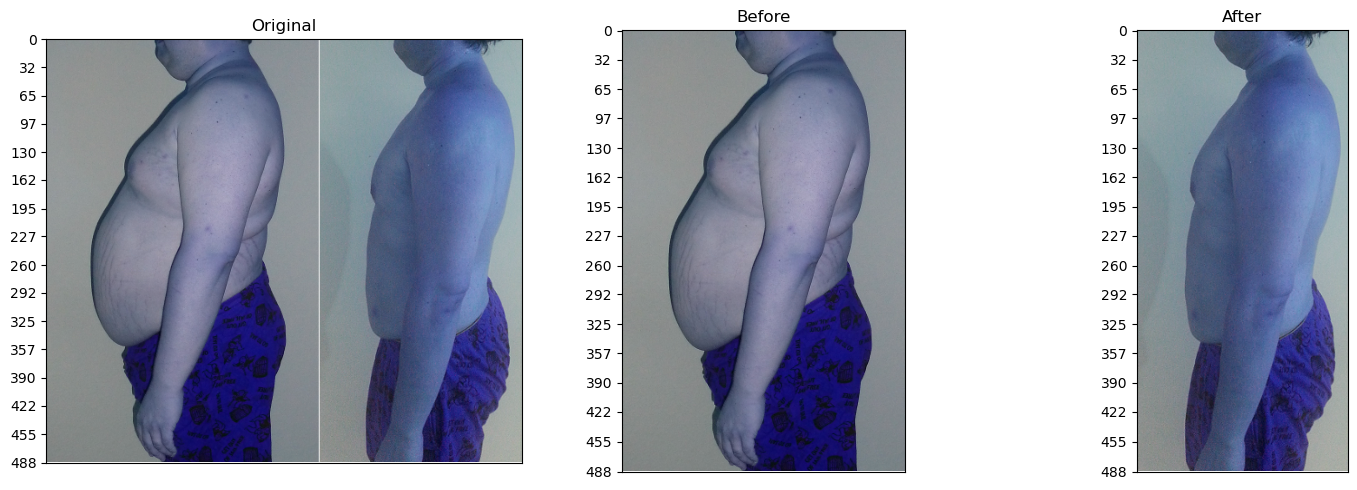

In [36]:
find_best_line_and_split(file_path = 'data/image_extraction/progresspics/url/1mm5rp.jpg', save=False)

### Convert color format

To ensure seamless reading and analysis of pixel hue, convert all to RGB .jpeg files.

Note if reading in image fails it is skipped as well, which is ideal.

In [37]:
def convert_images_to_rgb(input_dir, output_dir):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get a list of image files in the input directory
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    for image_file in image_files:
        input_path = os.path.join(input_dir, image_file)
        output_path = os.path.join(output_dir, image_file)

        try:
            # Open the image
            img = Image.open(input_path)

            # Check if the original image is in CMYK format
            if img.mode == 'CMYK':
                # Convert CMYK to RGB using the specified method
                img = ImageCms.profileToProfile(img, "CMYK", "sRGB", renderingIntent=0)

            # Convert to RGB
            img = img.convert('RGB')

            # Save the image as JPEG
            img.save(output_path, 'JPEG')

            #print(f"Converted {input_path} to {output_path}")

        except Exception as e:
            print(f"Error processing {input_path}: {e}")

In [ ]:
input_directory = 'data/image_extraction/progresspics/url/'
output_directory = 'data/image_extraction/progresspics/url_clean/'

convert_images_to_rgb(input_directory, output_directory)

In [56]:
# Get the paths to all the images that were downloaded from url
img_dir = 'data/image_extraction/progresspics/url_clean/'
url_images = pd.DataFrame({'path': [img_dir + x for x in os.listdir(img_dir)]}) # full paths
url_images.head()

,path
0,data/image_extraction/progresspics/url_clean/y...
1,data/image_extraction/progresspics/url_clean/3...
2,data/image_extraction/progresspics/url_clean/1...
3,data/image_extraction/progresspics/url_clean/x...
4,data/image_extraction/progresspics/url_clean/n...


In [59]:
before_dir = 'data/image_extraction/progresspics/split_url/before/'
after_dir = 'data/image_extraction/progresspics/split_url/after/'
before_complete = [x.split('/')[-1].split('.')[0] for x in os.listdir(before_dir)]
after_complete = [x.split('/')[-1].split('.')[0] for x in os.listdir(after_dir)]
complete_split = list(set(before_complete) | set(after_complete))

#### Format for dask

In [63]:
def map_split(df_):
    return df_.apply(save_split, axis= 1) # return strings
def save_split(row, complete_list = complete_split):
    # Check that we didn't already do this one:
    id_ = row['path'].split('/')[-1].split('.')[0]
    if not id_ in complete_list:
        return find_best_line_and_split(row['path'], before_dir, after_dir, save = True)
ddf = dd.from_pandas(url_images, npartitions = 30)
task = ddf.map_partitions(map_split, meta = (None, 'str'))

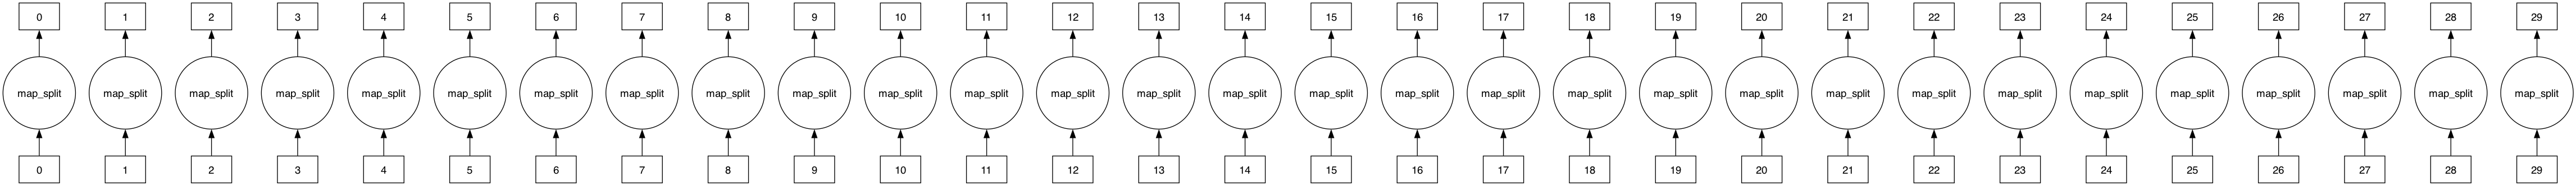

In [67]:
task.visualize()

In [65]:
with ProgressBar():
    complete_urls = task.compute()

[########################################] | 100% Completed | 61m 53s


In [71]:
# Copy the ones that are in both before and after into img/before and img/after
split_before = os.listdir('data/image_extraction/progresspics/split_url/before/')
split_after = os.listdir('data/image_extraction/progresspics/split_url/after/')
in_both = list(set(split_before) & set(split_after))
in_both[0:2]

['60mnpi.jpg', 'wgp1lj.jpg']

In [77]:
split_url_df = pd.DataFrame({'file': in_both})
ddf = dd.from_pandas(split_url_df, npartitions = 30)

/Users/iandouglas/miniconda3/lib/python3.10/site-packages/dask/dataframe/utils.py:312: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series([], dtype=dtype, name=name, index=index)


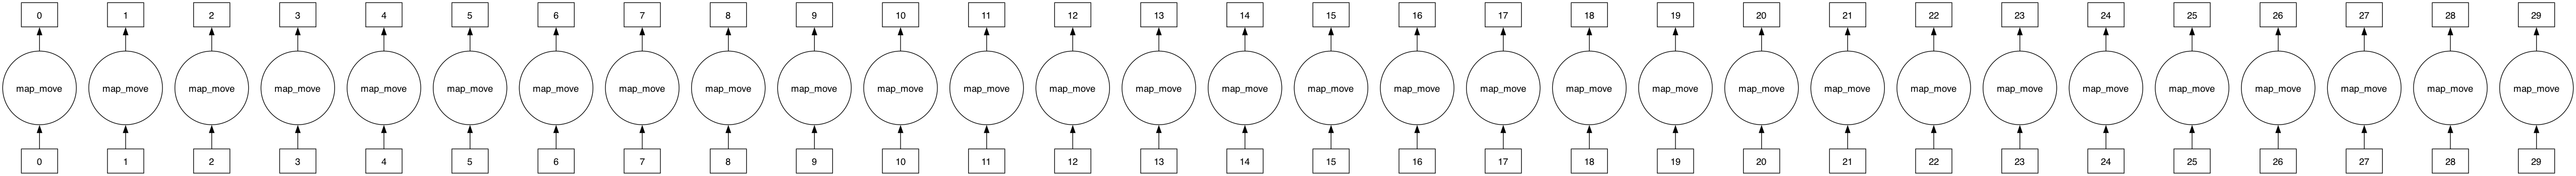

In [78]:
#import subprocess
def apply_move(row):
    before_from_ = f"data/image_extraction/progresspics/split_url/before/{row['file']}"
    before_to_ = f"data/img/before/{row['file']}"
    sh.move(before_from_, before_to_)
    after_from_ = f"data/image_extraction/progresspics/split_url/after/{row['file']}"
    after_to_ = f"data/img/after/{row['file']}"
    sh.move(after_from_, after_to_)
def map_move(df_):
    return df_.apply(apply_move, axis = 1)
task = ddf.map_partitions(map_move, meta = (None, None))
task.visualize()

In [79]:
with ProgressBar():
    res = task.compute()

[########################################] | 100% Completed | 17.12 s
